Redes CNN

Redes convuliocinales

In [2]:
#@markdown ---------------
#@markdown ## **⚠️❗ Ejecute esta celda para descargar Shoes dataset❗⚠️**
#@markdown ### Esta celda creará la carpeta ```/content/shoes_data```

!pip install -qq gdown
!gdown -qq "https://drive.google.com/uc?id=1_fIMm5nPp0BLJZKfkJZ_juRmLpRK4iA0" -O /shoes_data.zip
!mkdir /content/shoes_data/
!unzip -qq /shoes_data.zip -d /content/shoes_data
!rm -r /shoes_data.zip
print ("Done!")
#@markdown ---------------

mkdir: cannot create directory ‘/content/shoes_data/’: File exists
Done!


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

import torch
from torch import nn
from torchsummary import summary
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [4]:
image_transforms = transforms.Compose([transforms.Resize((64,64), Image.BICUBIC),
                                       transforms.ToTensor()])

In [5]:
train_dataset = datasets.ImageFolder(root= '/content/shoes_data/train/' , transform = image_transforms )
test_dataset = datasets.ImageFolder(root= '/content/shoes_data/train/', transform = image_transforms )

train_loader = DataLoader(train_dataset, batch_size = 100 , shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 100 )

In [6]:
# grab a batch from both training and validation dataloader
trainBatch = next(iter(train_loader))
valBatch = next(iter(test_loader))

In [7]:
print (trainBatch[1].shape, valBatch[0].shape)

torch.Size([100]) torch.Size([100, 3, 64, 64])


In [8]:
def grid_images(list_images, grid_size=(3,3)):
  _, axes = plt.subplots(grid_size[0], grid_size[1], figsize= (3*grid_size[1],3*grid_size[0]))
  axes = axes.ravel()

  for img, ax in zip	(list_images,axes):
    if isinstance(img, torch.Tensor):
      img=img.numpy().transpose(1,2,0).squeeze() #el squeeze es para elminar las dimensiones de un solo canal
    ax.imshow(img, cmap='gray')
    ax.set_axis_off()


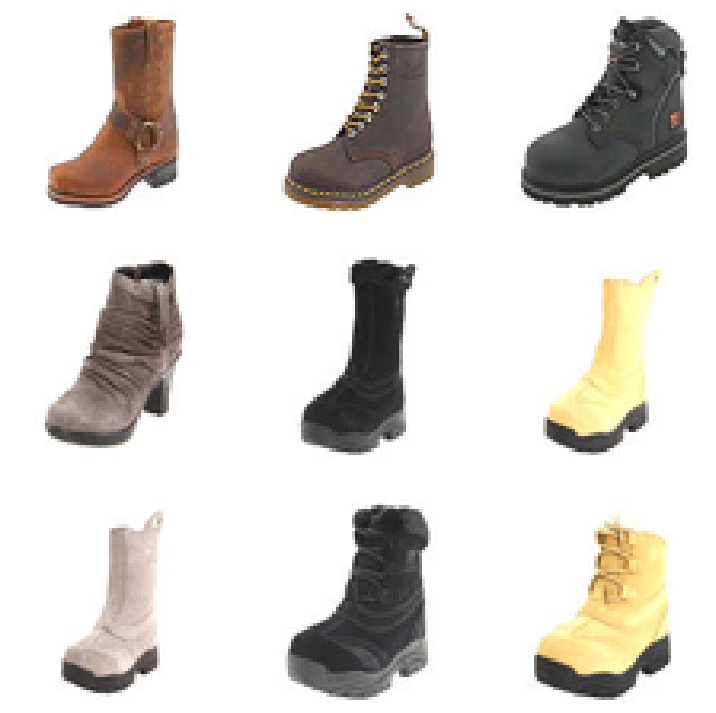

In [9]:
train_images = [train_dataset[i][0] for i in range(9)]
grid_images(train_images,grid_size=(3,3))

In [10]:
model = nn.Sequential(
    nn.Conv2d(3, 8, kernel_size=(3,3), padding=1), nn.ReLU(), nn.MaxPool2d(kernel_size=(2,2)),
    nn.Conv2d(8, 16, kernel_size=(3,3), padding=1), nn.ReLU(), nn.MaxPool2d(kernel_size=(2,2)),
    nn.Conv2d(16, 32, kernel_size=(3,3), padding=1), nn.ReLU(), nn.MaxPool2d(kernel_size=(2,2)),
    nn.Conv2d(32, 64, kernel_size=(3,3), padding=1), nn.ReLU(),
    nn.Flatten(),
    nn.Linear(64*8*8, 512), nn.ReLU(),
    nn.Linear(512, 256), nn.ReLU(),
    nn.Linear(256, 128), nn.ReLU(),
    nn.Linear(128, 3), nn.Softmax()
)



#Conv2d=canales, kernels (matrices),tamaño de las matrices,padding (bordes de los pixeles), ReLu es la activacion,siempre debe estar despues de eso,Maxpool= tamaño de la matriz de salida

model.cuda()
summary(model, input_size=( 3,64,64) ) #device='cpu'

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 64, 64]             224
              ReLU-2            [-1, 8, 64, 64]               0
         MaxPool2d-3            [-1, 8, 32, 32]               0
            Conv2d-4           [-1, 16, 32, 32]           1,168
              ReLU-5           [-1, 16, 32, 32]               0
         MaxPool2d-6           [-1, 16, 16, 16]               0
            Conv2d-7           [-1, 32, 16, 16]           4,640
              ReLU-8           [-1, 32, 16, 16]               0
         MaxPool2d-9             [-1, 32, 8, 8]               0
           Conv2d-10             [-1, 64, 8, 8]          18,496
             ReLU-11             [-1, 64, 8, 8]               0
          Flatten-12                 [-1, 4096]               0
           Linear-13                  [-1, 512]       2,097,664
             ReLU-14                  [

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1844: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return inner()


In [11]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
loss.cuda()

CrossEntropyLoss()

In [12]:
epochs = 100
batch_size = 200
losses = []

progress = tqdm(range( epochs ), ncols=110)

for epoch in progress:
  #
  batch_losses = 0

  # for batch_i in range(0, len(X_train) , batch_size):
  for batch_i, (batch_X, batch_y) in enumerate(train_loader):

    batch_X= batch_X.to('cuda')
    batch_y= batch_y.cuda()


    # Zero the gradients
    optimizer.zero_grad()

    # Perform forward pass
    predictions = model(batch_X)

    # Compute loss
    batch_loss = loss( predictions , batch_y )

    # Perform backward pass
    batch_loss.backward()

    # Optimize parameters
    optimizer.step()


    ## Save stats
    batch_losses += batch_loss.item()


  progress.set_description("Epoch [%d/%d] [Loss: %f]" % (epoch, epochs,
                                                         batch_losses / len(train_loader)))

  losses.append(batch_losses/(len(train_loader)))


  0%|                                                                                 | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Epoch [99/100] [Loss: 0.611034]: 100%|██████████████████████████████████████| 100/100 [16:28<00:00,  9.89s/it]


Text(0.5, 1.0, 'Cross Entropy loss')

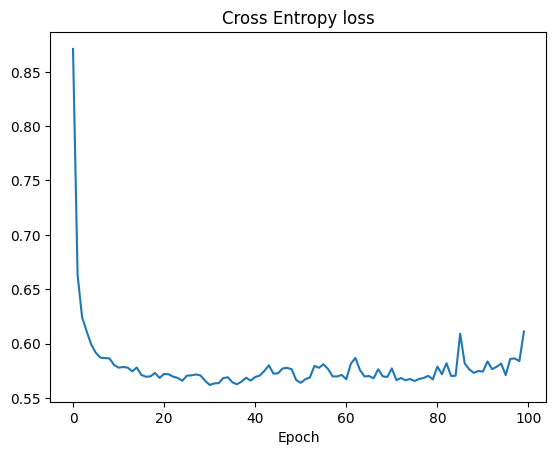

In [13]:
import seaborn as sns

plt.plot(np.array( losses ))
plt.xlabel("Epoch")
plt.title('Cross Entropy loss')

In [15]:
#barra de progreso
progress = tqdm (test_loader, ncols=90)

y_test_,predictions = [],[]

for(batch_x, batch_y) in progress:
  batch_X= batch_X.cuda()

  batch_pred = model(batch_X)
  predictions.extend(batch_pred.detach().cpu().numpy())
  y_test_.extend(batch_y.numpy())

predictions = np.argmax(predictions, axis=1)
y_test_ = np.array(y_test_)

  0%|                                                             | 0/120 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|███████████████████████████████████████████████████| 120/120 [00:11<00:00, 10.60it/s]


Accuracy: 0.33333


<Axes: >

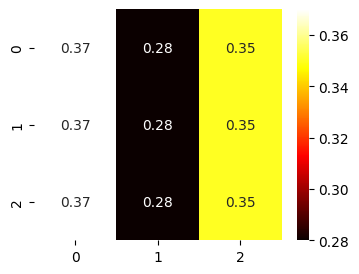

In [16]:
from sklearn.metrics import accuracy_score, confusion_matrix

acc_ = accuracy_score(y_test_,predictions)
cm_ = confusion_matrix(y_test_,predictions,normalize='true')

print('Accuracy: {0:0.5f}'.format(acc_))


_, ax= plt.subplots(figsize=(4,3))
sns.heatmap(cm_, annot=True,cmap='hot',ax=ax)